In [1]:

from matplotlib import pyplot as plt
import os
import numpy as np
import glob
import os

## astropy
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii 


## ctapipe
from ctapipe_io_nectarcam import NectarCAMEventSource 
from ctapipe import utils
from pkg_resources import resource_filename
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
# ~ from ctapipe.image import hillas_parameters, tailcuts_clean
from ctapipe.image import *
from ctapipe.image.cleaning import apply_time_delta_cleaning, number_of_islands, fact_image_cleaning

## LOCAL
#from utils import *
#from PulseTemplate import *
#from scan_L1A_delays_fit import *
#from wf_fit_utils  import likelyhood_fct_spe

# scipy
from scipy import stats, optimize, interpolate
from scipy.optimize import curve_fit, minimize
from scipy.stats import gaussian_kde

import matplotlib.image as image
import math 
import pandas as pd
#import seaborn as sns

from ctapipe.io import event_source, EventSeeker             



def get_full_pedestals(filename):
    inputfile_reader = NectarCAMEventSource(
        input_url = filename,
        max_events=10000)
    expected_pixs = inputfile_reader.camera_config.expected_pixels_id
    all_wfs = []
    for ii, event in enumerate(inputfile_reader):
        if event.r0.tel[event.r0.tels_with_data[0]].trigger_type == 32:
            all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,expected_pixs])
            if len(all_wfs) > 1000:
                break
    all_wfs = np.array(all_wfs)
    return all_wfs.mean(axis=0)

def get_Qs(inputfile_reader,gains,HGLG,ped_hg,ped_lg):

    hg_lg   = []
    mm   = 33
    smin = 4
    smax = 8
    T0 = 0 
    Qs    = []
    Q_hgs = []
    Q_lgs = []
    
    for ii, event in enumerate(inputfile_reader):
        if event.r0.tel[event.r0.tels_with_data[0]].trigger_type != 32:
            wfs = event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids]
            Q_hg = (wfs[0] - ped_hg)[:,mm-smin:mm+smax].sum(axis=1) / gains
            Q_lg = (wfs[1] - ped_lg)[:,mm-smin:mm+smax].sum(axis=1) / gains * HGLG
            
            Q_hgs.append(Q_hg)
            Q_lgs.append(Q_lg)
    return np.array(Q_hgs),np.array(Q_lgs)

/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/corsikaio/subblocks/dtypes.py:20: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dict(**dt))


In [2]:
plt.rcParams['figure.figsize'] = [15, 7]

In [3]:
gains =  np.load("./gains.npy")
HGLG =  np.load("./hg_lg.npy")

plot=False
gain=58.
gains = np.ones(427)*gain

table = Table.read('./NewNectarCam.camgeom.fits.gz')
geom = CameraGeometry.from_table(table)
geom.rotate(10.3*u.deg)

file_path = '/local/home/ttaverni/cta-nectar/NectarCamPyUaf/cta/MyNectar/scripts/Nectarpipe_2.0/XT/NectarCAM.Run1575.00[0-9][0-9].fits.fz'
pedestals = get_full_pedestals(file_path)

inputfile_reader = NectarCAMEventSource(
    input_url = file_path,
    max_events=500000)

cfg = inputfile_reader.camera_config
pix_ids = cfg.expected_pixels_id

testpix_id = 2+134*7
offpix_id =  3+153*7
Q_hgs, Q_lgs = get_Qs(inputfile_reader,gains,HGLG,pedestals[0],pedestals[1])



qs1 = Q_hgs[:,np.where(pix_ids==testpix_id)[0][0]]
nbh_pixs_id = np.arange(0,1855)[geom.neighbor_matrix[testpix_id]]
nbh_pixs_indexs = np.array([ np.where(pix_ids==pix_id)[0][0] for pix_id in nbh_pixs_id] )
nb_Qs =  Q_hgs[:, nbh_pixs_indexs]


Off_modules = [116,117,118,134,135,136,151,152,153]
Off_pixs_id = np.array([np.arange(6) + mod*7 for mod in Off_modules]).flatten()
Off_pixs_indexs = np.array([ np.where(pix_ids==pix_id)[0][0] for pix_id in Off_pixs_id[Off_pixs_id != testpix_id]] )




/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/scipy/sparse/lil.py:510: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


(-0.6, 0.6)

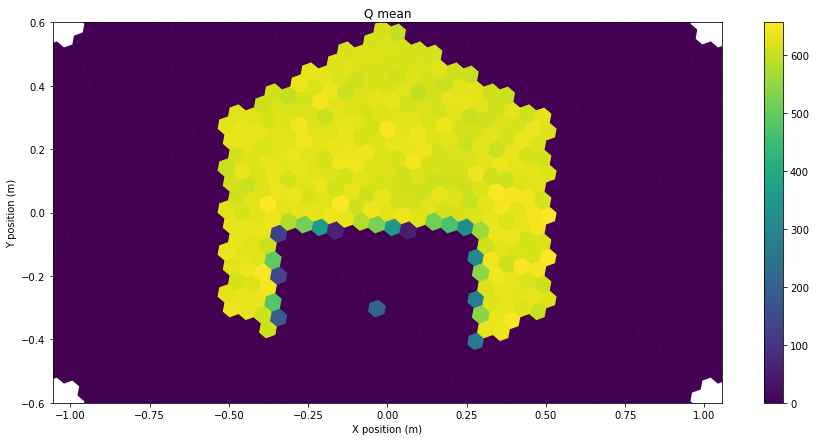

In [4]:
disp1 = CameraDisplay(geom,title="Q mean")
disp1.add_colorbar()
blankam = np.zeros(1855)
blankam[pix_ids] = Q_hgs.mean(axis=0)
disp1.image = blankam
#plt.gca().plot(geom.pix_x[testpix_id].value,geom.pix_y[testpix_id].value,'o',color = 'red')
plt.gca().set_xlim(-.6,+.6)
plt.gca().set_ylim(-.6,+.6)

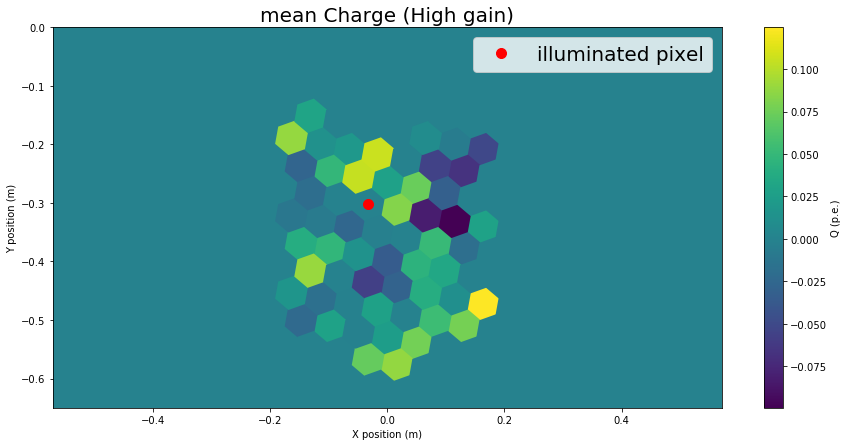

In [5]:
disp1 = CameraDisplay(geom,title="mean Charge (High gain)")
plt.gca().set_title("mean Charge (High gain)",fontsize=20)
disp1.add_colorbar(label = "Q (p.e.)")
blankam = np.zeros(1855)
blankam[pix_ids[Off_pixs_indexs]] = Q_hgs.mean(axis=0)[Off_pixs_indexs]
disp1.image = blankam
plt.gca().plot(geom.pix_x[testpix_id].value,geom.pix_y[testpix_id].value,'o',color = 'red',ms=10,label='illuminated pixel')
plt.gca().set_xlim(-.4,+.4)
plt.gca().set_ylim(-.65,0)
plt.gca().legend(prop={'size':20})

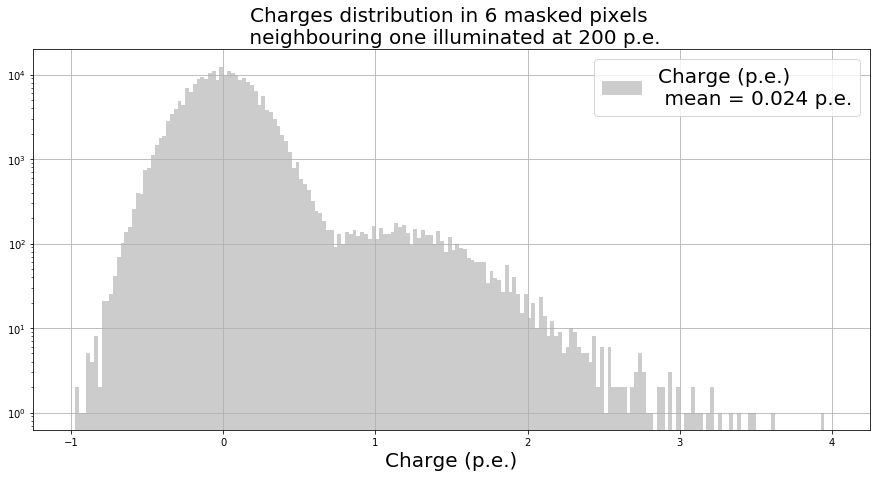

In [6]:
h= plt.hist(Q_hgs[:,nbh_pixs_indexs].flatten(),200,range=(-1,4),alpha=.2,color='black',\
            label='Charge (p.e.) \n mean = {:.2} p.e.'.format(Q_hgs[:,nbh_pixs_indexs].mean()))
plt.gca().set_yscale('log')
plt.gca().set_title("Charges distribution in 6 masked pixels \n neighbouring one illuminated at 200 p.e.",fontsize=20)
plt.gca().legend(prop={'size':20})
plt.gca().set_xlabel('Charge (p.e.)',fontsize=20 )
plt.gca().grid()


In [ ]:
OffOff_pixs =[]
for pix in Off_pixs_indexs:
    if pix not in nbh_pixs_indexs:
        OffOff_pixs.append(pix)
h= plt.hist(Q_hgs[:,nbh_pixs_indexs].flatten(),100,range=(-1,4),alpha=.2,color='black',density=1.,label='neighbour pixels')
h= plt.hist(Q_hgs[:,OffOff_pixs].flatten(),100,range=(-1,4),alpha=.2,color='red',density=1.,label='other masked pixels')

plt.gca().set_yscale('log')
plt.gca().set_title("Charges distribution",fontsize=20)
plt.gca().legend(prop={'size':20})
plt.gca().set_xlabel('Charge (p.e.)',fontsize=20 )
plt.gca().grid()

In [ ]:
qs1.mean()

In [ ]:
(Q_hgs[:,nbh_pixs_indexs].mean())/qs1.mean()

In [ ]:
expected_modules_id = cfg.nectarcam.expected_modules_id

In [ ]:
nbh_pixs_indexs

In [ ]:
comodule_pix_index = np.array([0,1,3,4,5]) + np.where(expected_modules_id == 134)[0][0]*7
comodule_pix_index

In [ ]:
h= plt.hist(Q_hgs[:,[225, 227, 228]].flatten(),100,range=(-1,4),alpha=.2,color='red',density=1.,label='co-module nbh pixels')
h= plt.hist(Q_hgs[:,[168, 174, 236]].flatten(),100,range=(-1,4),alpha=.2,color='black',density=1.,label='alt module nbh pixels')
#h= plt.hist(Q_hgs[:,OffOff_pixs].flatten(),100,range=(-1,4),alpha=.2,color='green',density=1.,label='OFF pixels')
plt.gca().set_yscale('log')
plt.gca().legend()
plt.gca().set_title("Charges distribution",fontsize=20)
plt.gca().legend(prop={'size':20})
plt.gca().set_xlabel('Charge (p.e.)',fontsize=20 )

In [ ]:
refmodule = 153
refmodule_pix_index = np.array([0,1,2,3,4,5]) + np.where(expected_modules_id == 153)[0][0]*7
h= plt.hist(Q_hgs[:,comodule_pix_index].flatten(),100,range=(-1,4),alpha=.2,color='red',density=1.,label='co_module pixels')
h= plt.hist(Q_hgs[:,refmodule_pix_index].flatten(),100,range=(-1,4),alpha=.2,color='black',density=1.)

plt.gca().set_yscale('log')
plt.gca().legend()

In [ ]:
refmodule = 152
refmodule_pix_index = np.array([0,1,2,3,4,5]) + np.where(expected_modules_id == 152)[0][0]*7
h= plt.hist(Q_hgs[:,comodule_pix_index].flatten(),100,range=(-1,4),alpha=.2,color='red',density=1.,label='co_module pixels')
h= plt.hist(Q_hgs[:,refmodule_pix_index].flatten(),100,range=(-1,4),alpha=.2,color='black',density=1.)

plt.gca().set_yscale('log')
plt.gca().legend()

In [ ]:
refmodule = 117
refmodule_pix_index = np.array([0,1,2,3,4,5]) + np.where(expected_modules_id == refmodule)[0][0]*7
h= [plt.hist(Q_hgs[:,refmodule_pix_index[n]],100,range=(-1,4),alpha=.2,density=1.) for n in np.array([0,1,2,3,4,5])]

plt.gca().set_yscale('log')
plt.gca().legend()

In [ ]:
    inputfile_reader = NectarCAMEventSource(
        input_url = file_path,
        max_events=10000)
    expected_pixs = inputfile_reader.camera_config.expected_pixels_id
    all_wfs = []
    for ii, event in enumerate(inputfile_reader):
        if event.r0.tel[event.r0.tels_with_data[0]].trigger_type == 32:
            all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,expected_pixs])
            if len(all_wfs) > 1000:
                break
    all_wfsp = np.array(all_wfs)

In [ ]:
    inputfile_reader = NectarCAMEventSource(
        input_url = file_path,
        max_events=10000)
    expected_pixs = inputfile_reader.camera_config.expected_pixels_id
    all_wfs = []
    for ii, event in enumerate(inputfile_reader):
        if event.r0.tel[event.r0.tels_with_data[0]].trigger_type != 32:
            all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,expected_pixs])
            if len(all_wfs) > 1000:
                break
    all_wfs = np.array(all_wfs)

In [ ]:
all_wfs.shape

In [ ]:
np.where(expected_modules_id == refmodule)[0][0]

In [ ]:
m=plt.plot(all_wfs[:,0, np.where(expected_modules_id == 153)[0][0]*7+1,:].T,color='black',alpha=.1)

In [ ]:
1/(2*u.deg.to('rad'))

In [ ]:
1/60.